# Evaluation of Results for Synthetic Functions

In [2]:
library(ggplot2)
library(data.table)
library(BBmisc)

library(GGally)

library(ggpubr)

theme_set(theme_pubr())

In [3]:
savepath = file.path("..", "data", "runs", "synthetic_enhanced_eval")

runs = paste0("StyblinskiTang", c(3, 5, 8), "D")

In [4]:
res = lapply(c(3, 5, 8), function(dimension) {
    out = lapply(c("L2"), function(obj) {
        
        df = readRDS(file.path(savepath, paste0("StyblinskiTang", dimension, "D"), paste0("eval_SS_", obj, ".rds")))[n.splits == 5, ]
        
        res = lapply(seq_row(df), function(i) {
            cbind(iter = i, lambda = df$lambda[i], df$result[[i]]$eval, mmd2 = df$result[[i]]$mmd2)
        })
        
        res = do.call(rbind, res)
        res$objective = obj
        res
    })
    
    out = do.call(rbind, out)
    
    out$dimension = dimension
    out
})

In [5]:
res = do.call(rbind, res)

In [6]:
res$neg_loglik.cov.rel = (res$source.neg_loglik.cov - res$neg_loglik.cov) / abs(res$source.neg_loglik.cov)
res$neg_loglik.rel = (res$source.neg_loglik - res$neg_loglik) / abs(res$source.neg_loglik)

Show a coordinate plot that highlights the relation between dimensionality, lambda, and the performance of the final plot. 

In [7]:
# We only have a look at the "source" node here. 

df = setDT(res)

df = df[, c("iter", "depth", "mmd2", "objective", "lambda", "conf.diff", "neg_loglik", "neg_loglik.rel", "neg_loglik.cov.rel", "conf.rel", "source.conf.diff", "source.gt.diff.abs", "source.gt.diff.sd", "source.neg_loglik", "dimension", "conf.rel.cov", "conf.diff.cov", "neg_loglik.cov")]

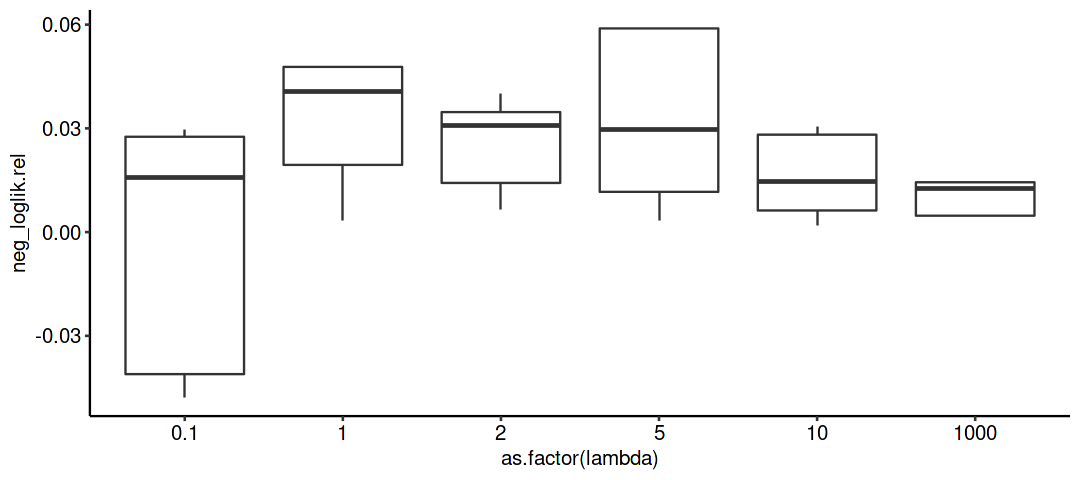

In [38]:
p = ggplot(data = df[depth == 2, ], aes(x = as.factor(lambda), y = neg_loglik.rel)) + geom_boxplot()
p

In [8]:
dfs = df[lambda %in% c(0.1, 1, 5)]
dfs$lambda = as.factor(dfs$lambda)
levels(dfs$lambda) = c("high", "medium", "low")

dfs$d = as.factor(dfs$dimension)

dfs = dfs[, .(`neg_loglik` = round(mean(neg_loglik.rel) * 100, 2), `neg_loglik.sd` = round(sd(neg_loglik.rel) * 100, 2),  `diff.conf` = round(mean(conf.rel) * 100, 2), `diff.conf.sd` = round(sd(conf.rel) * 100, 2), `mmd` = round(mean(sqrt(mmd2)), 2)), by = c("lambda", "d", "depth")]

In [9]:
names(dfs)

[1] "lambda"        "d"             "depth"         "neg_loglik"   
[5] "neg_loglik.sd" "diff.conf"     "diff.conf.sd"  "mmd"

In [10]:
df1 = dfs[depth %in% c(2), c("d", "lambda", "mmd", "neg_loglik", "neg_loglik.sd", "diff.conf", "diff.conf.sd")]
# names(df1)[3:4] = c("Red. in diff (depth 2)", "Red. in NegLoglik (depth 2)")

df2 = dfs[depth %in% c(4), c("d", "lambda", "mmd", "neg_loglik", "neg_loglik.sd", "diff.conf", "diff.conf.sd")]
# names(df2)[3:4] = c("Red. in diff (depth 4)", "Red. in NegLoglik (depth 4)")

out = batchtools::ijoin(df1, df2, by = c("d", "lambda", "mmd"))

# write.csv(out[c(3:1, 6:4, 9:5), c(2:1, 3, 5, 4, 6)], "out.csv")

In [11]:
out[c(3:1, 6:4, 9:7), ]

d,lambda,mmd,neg_loglik,neg_loglik.sd,diff.conf,diff.conf.sd,i.neg_loglik,i.neg_loglik.sd,i.diff.conf,i.diff.conf.sd
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,low,0.18,5.89,0.00,7.65,0.00,10.92,0.00,13.64,0.00
3,medium,0.51,4.78,0.00,12.86,0.00,7.70,0.01,36.92,0.01
3,high,0.56,2.77,0.27,16.52,0.30,-1.62,1.00,34.84,0.44
5,low,0.15,2.82,0.41,6.63,0.64,6.05,0.63,15.45,0.83
5,medium,0.45,4.05,0.05,19.67,0.23,7.80,0.22,37.28,0.15
5,high,0.53,-3.86,1.70,11.99,0.13,-1.93,1.63,33.06,0.21
8,low,0.11,0.84,0.41,3.58,0.75,2.40,0.64,9.67,1.27
8,medium,0.42,1.51,0.55,8.86,1.52,3.30,1.02,23.03,2.93
8,high,0.56,1.53,0.08,6.59,0.19,4.29,0.19,19.84,0.57


In [12]:
# out$neg_loglik = paste0(out$neg_loglik, " (", out$neg_loglik.sd, ")")
out$neg_loglik.sd = NULL
# out$i.neg_loglik = paste0(out$i.neg_loglik, " (", out$i.neg_loglik.sd, ")")
out$i.neg_loglik.sd = NULL


# out$diff.conf = paste0(out$diff.conf, " (", out$diff.conf.sd, ")")
out$diff.conf.sd = NULL
# out$i.diff.conf = paste0(out$i.diff.conf, " (", out$i.diff.conf.sd, ")")
out$i.diff.conf.sd = NULL

out$tau = paste0(out$lambda, " (", out$mmd, ")")

In [44]:
out

d,lambda,mmd,neg_loglik,diff.conf,i.neg_loglik,i.diff.conf,tau
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3,high,0.56,2.77,16.52,-1.62,34.84,high (0.56)
3,medium,0.51,4.78,12.86,7.70,36.92,medium (0.51)
3,low,0.18,5.89,7.65,10.92,13.64,low (0.18)
5,high,0.53,-3.86,11.99,-1.93,33.06,high (0.53)
5,medium,0.45,4.05,19.67,7.80,37.28,medium (0.45)
5,low,0.15,2.82,6.63,6.05,15.45,low (0.15)
8,high,0.56,1.53,6.59,4.29,19.84,high (0.56)
8,medium,0.42,1.51,8.86,3.30,23.03,medium (0.42)
8,low,0.11,0.84,3.58,2.40,9.67,low (0.11)


In [45]:
library(xtable)
print(xtable(out[c(3:1, 6:4, 9:7), c(1, 8, 5, 7, 4, 6)], type = "latex"), file = "out.tex", include.rownames = FALSE)

In [13]:
df$d = as.factor(df$dimension)

In [14]:
dfs = df[lambda %in% c("0.1", "1", "5"), ]

In [15]:
dfs$lambda = as.factor(dfs$lambda)

In [33]:
p1 = ggplot(data = dfs, aes(x = lambda, y = 1 / 20 * source.conf.diff, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Sampling Bias") + ylab("MC") + theme(legend.position = "none") + xlab("\u03C4")
# p1 = p1 + geom_boxplot(data = df[depth == 3, ], aes(x = lambda, y = 1 / 20 * conf.diff, colour = d), linetype = "dotted")

# p2 = ggplot(data = dfs, aes(x = source.neg_loglik, y = source.gt.diff.abs, colour = d)) + geom_point()
# p2 = p2 + ylab("Error in PDP Estimate") + xlab("Avg. Negative Log-Likelihood") + theme(legend.position = "right")
p2 = ggplot(data = dfs, aes(x = lambda, y = source.neg_loglik, colour = d)) + geom_boxplot() + theme(legend.position = "right")
# p2 = p2 + geom_boxplot(data = dfs[depth == 3, ], aes(x = lambda, y = neg_loglik, colour = d), linetype = "dotted")

p2 = p2 + xlab("\u03C4") + ylab("NLL")

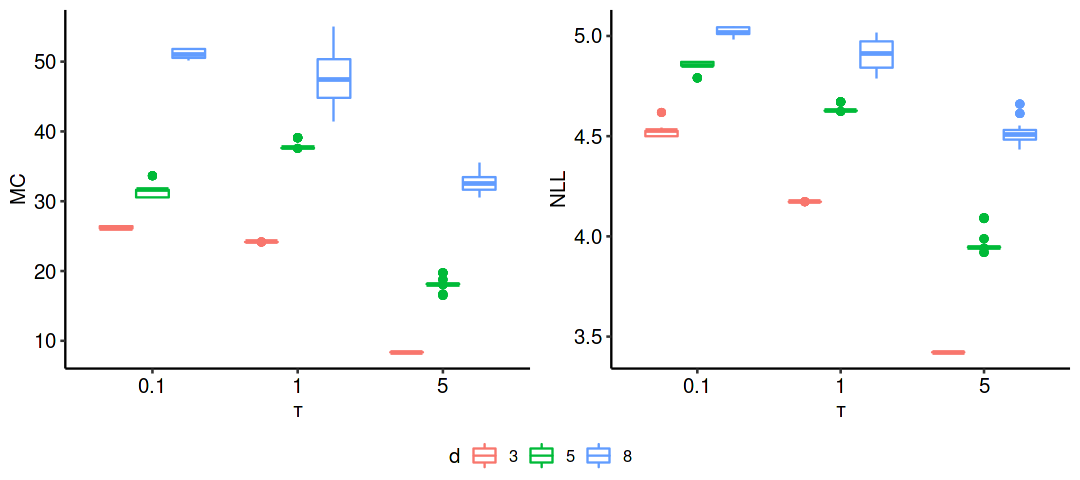

In [36]:
options(repr.plot.width = 9, repr.plot.height = 4)

p = ggarrange(p1, p2, ncol=2, common.legend = TRUE, legend="bottom")
p

ggsave(filename = "exploration_vs_confidence.png", p, width = 5, height = 2.3)

In [187]:
df$lambda = as.factor(df$lambda)
df$dimension = as.factor(df$dimension)

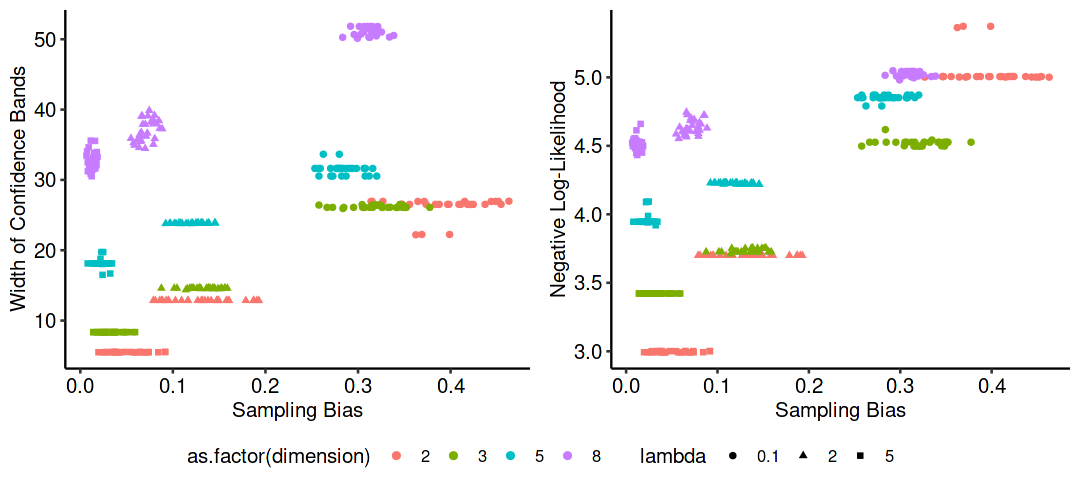

In [188]:
dfsub = df[depth == 2 & lambda %in% c("0.1", "2", "5"), ]

p1 = ggplot(data = dfsub, aes(x = mmd2, y = 1 / 20 * source.conf.diff, colour = as.factor(dimension), shape = lambda)) + geom_point()
p1 = p1 + xlab("Sampling Bias") + ylab("Width of Confidence Bands") # + theme(legend.position = "none")

p2 = ggplot(data = dfsub, aes(x = mmd2, y = source.neg_loglik, colour = as.factor(dimension), shape = lambda)) + geom_point()
p2 = p2 + xlab("Sampling Bias") + ylab("Negative Log-Likelihood") # + theme(legend.position = "none")

ggarrange(p1, p2, ncol=2, common.legend = TRUE, legend="bottom")


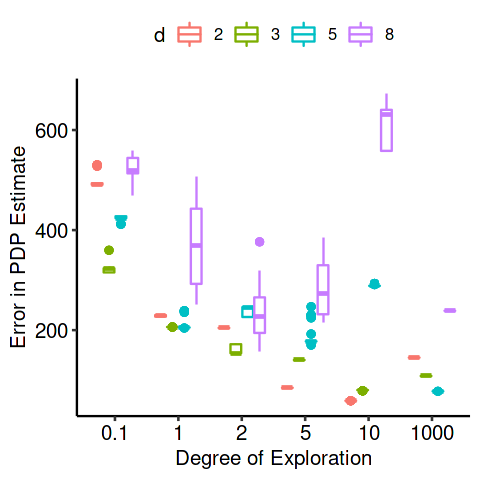

In [190]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = df, aes(x = lambda, y = source.gt.diff.abs, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Degree of Exploration") + ylab("Error in PDP Estimate")
p1

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'neg_loglik' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. pas

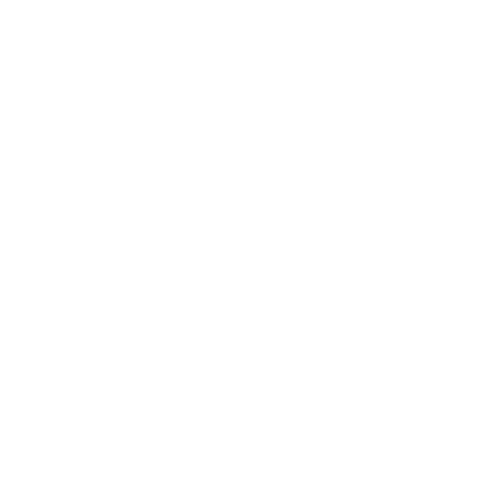

In [94]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = dfs[lambda == "high", ], aes(x = as.factor(depth), y = neg_loglik, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Negative Log-Likelihood")
p1

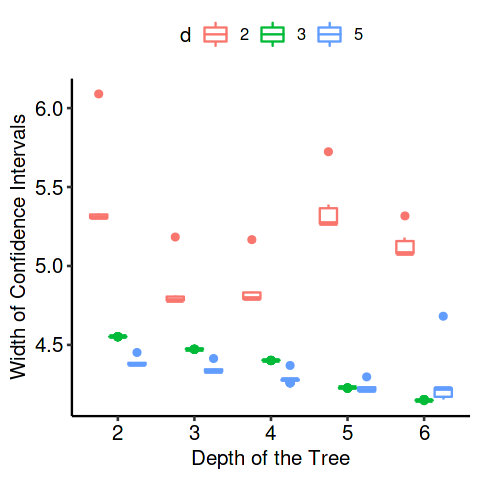

In [488]:
options(repr.plot.width = 4, repr.plot.height = 4)

p1 = ggplot(data = dfs[lambda == "high" & objective == "L1", ], aes(x = as.factor(depth), y = neg_loglik, colour = d)) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Width of Confidence Intervals")
p1

In [ ]:
dfs$conf.rel = - dfs$conf.rel

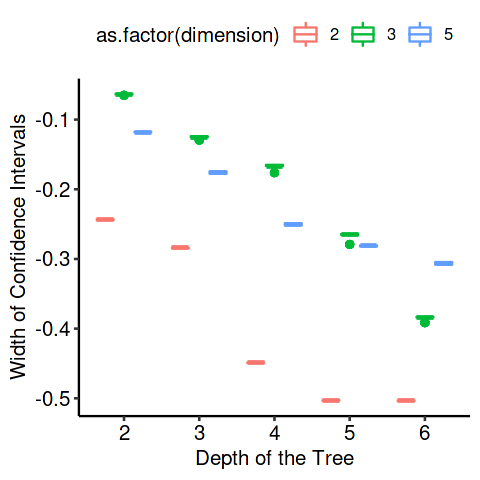

In [434]:
p1 = ggplot(data = dfs[lambda == "medium" & objective == "sd", ], aes(x = as.factor(depth), y = conf.rel, colour = as.factor(dimension))) + geom_boxplot()
p1 = p1 + xlab("Depth of the Tree") + ylab("Width of Confidence Intervals")
p1

In [42]:
dfs

lambda,d,depth,Splitted,diff.conf
<fct>,<fct>,<int>,<dbl>,<dbl>
high,2,2,1.72,1.86
high,2,3,-14.89,10.39
high,2,4,-314.33,18.98
high,2,5,-703528.66,27.03
high,2,6,-2032994.60,28.01
medium,2,2,5.90,-0.62
medium,2,3,21.78,9.16
medium,2,4,21.62,8.84
medium,2,5,20.16,5.24


# Compare two variants of the negative log likelihood

In [69]:
dfsub = setDT(res)
dfsub = dfsub # [depth == 2, ]
dfsub$dimension = as.factor(dfsub$dimension)

dfsub = reshape2::melt(data = dfsub, id.vars = c("dimension", "lambda"), measure.vars = c("neg_loglik", "neg_loglik.cov"))

In [74]:
p = ggplot(data = dfsub, aes(x = dimension, y = value, colour = variable)) + geom_boxplot()

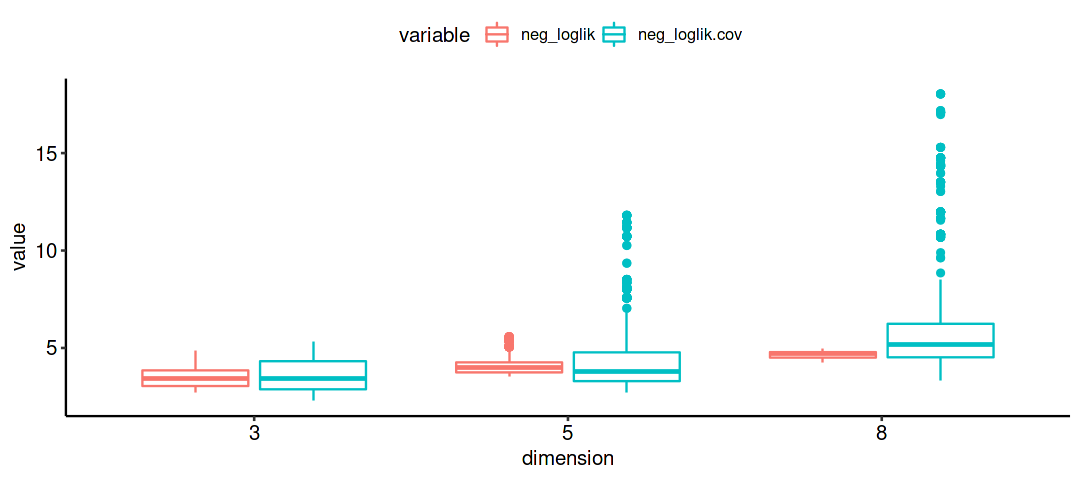

In [75]:
p